## Clonning the GitHub Repository

To get the following link, go to the official GitHub repository of Janus (link in the description) and copy https link as shown in the image below.

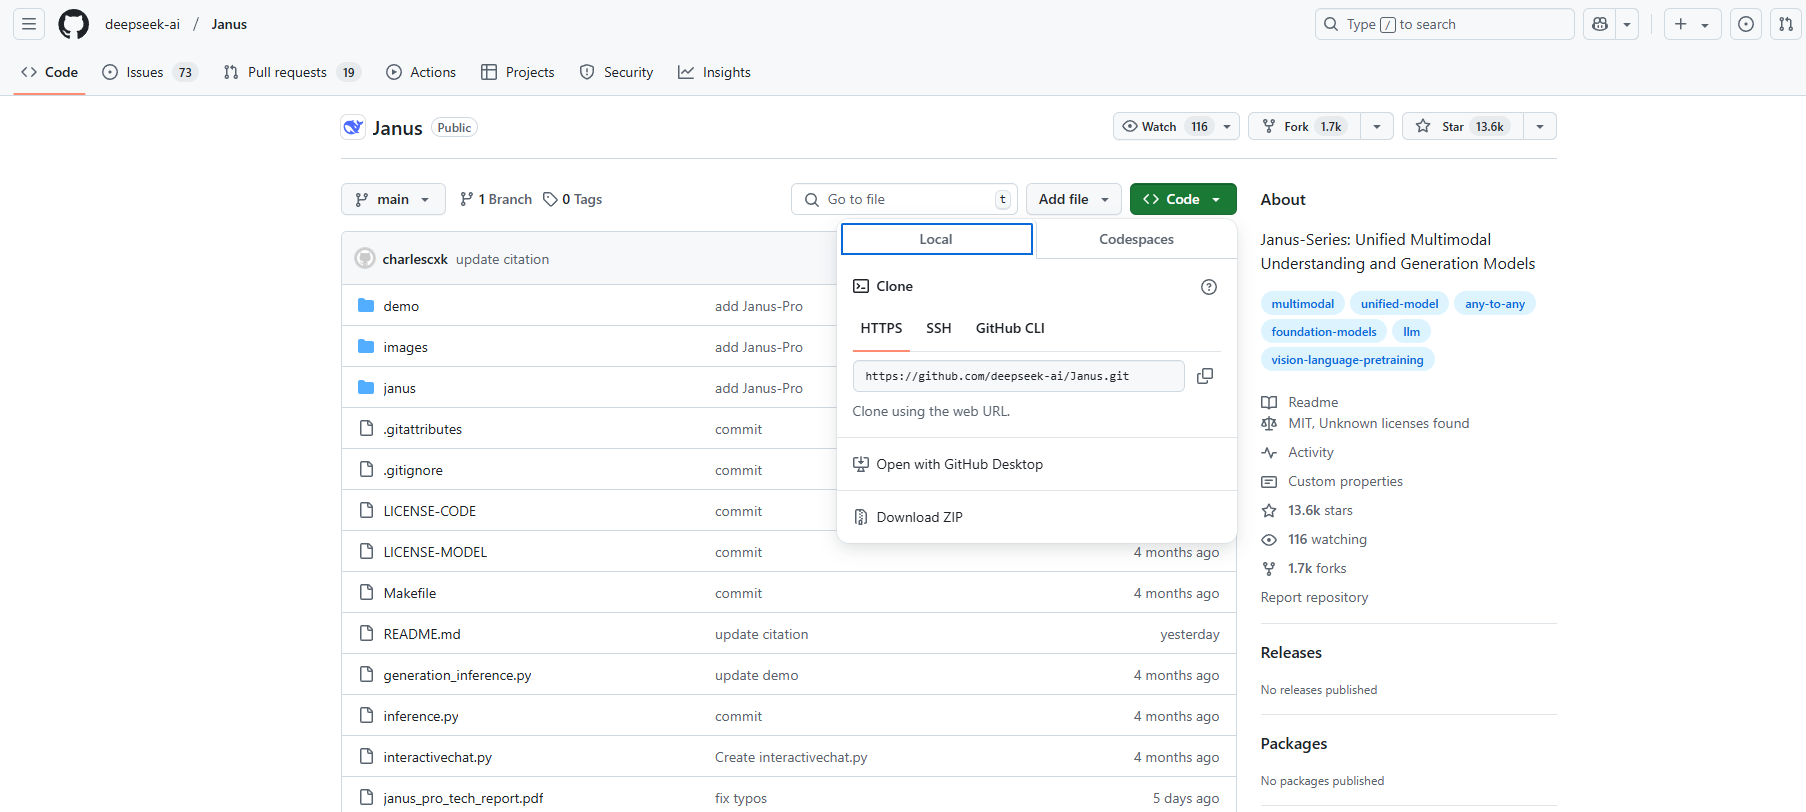

In [1]:
!git clone https://github.com/deepseek-ai/Janus.git

Cloning into 'Janus'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 121 (delta 52), reused 39 (delta 38), pack-reused 46 (from 1)
Receiving objects: 100% (121/121), 7.18 MiB | 13.67 MiB/s, done.
Resolving deltas: 100% (58/58), done.


## Changing the working directory into Janus

In [2]:
%cd Janus

/content/Janus


## Installing the essential requirements

In [3]:
!pip install -e . -q
!pip install flash-attn -q

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.3 MB/s eta 0:0

## 1. Importing Necessary Libraries

In [6]:
import torch
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

## 2. Define Model Path and Initialize Processor

In [7]:
model_path = "deepseek-ai/Janus-1.3B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/106k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.72M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


processor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: num_image_tokens, ignore_id, mask_prompt, image_tag, add_special_token, sft_format. 


Add image tag = <image_placeholder> to the tokenizer


## 3. Load Pretrained Multi-Modality Model

In [8]:
vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True,
    attn_implementation="eager",
    torch_dtype=torch.float16,  # Ensure model uses float16
    device_map="auto"  # Automatically assigns to GPU if available
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

## 4. Define User Conversation Input

In [9]:
conversation = [
    {
        "role": "User",
        "content": "<image_placeholder>\n Extract all the possible features in the bullet points for this image",
        "images": ["../nature.png"],
    },
    {"role": "Assistant", "content": ""},
]

## 5. Load and Prepare Image Inputs

In [10]:
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

## 6. Generate Image Embeddings

In [11]:
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

In [12]:
inputs_embeds

tensor([[[ 0.0403, -0.0198, -0.7227,  ..., -0.0205,  0.0133,  0.0121],
         [ 0.1270, -0.0181, -0.1592,  ...,  0.2393, -0.0952,  0.0175],
         [-0.0271, -0.1836, -0.0913,  ..., -0.1172, -0.1216, -0.1377],
         ...,
         [ 0.2637, -0.0197, -0.0498,  ...,  0.0149, -0.0175, -0.0330],
         [-0.0327, -0.0063, -0.0767,  ...,  0.0223, -0.0825,  0.0332],
         [ 0.0991,  0.0776, -0.1494,  ...,  0.1289, -0.0864, -0.0123]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<IndexPutBackward0>)

## 7. Generate Model Response

In [ ]:
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

## 8. Decode and Print the Answer

In [ ]:
answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)

You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

User: <image_placeholder>
 Extract all the possible features in the bullet points for this image

Assistant: The image depicts a serene natural scene featuring a flowing river surrounded by dense forest. Here are the key features extracted from the image:

1. **River**: The river is the central element of the image, flowing through a rocky bed. The water appears to be clear and has a gentle current.

2. **Rocks**: The riverbed is filled with numerous large and small rocks, creating a natural and rugged terrain. The rocks vary in size and are scattered throughout the river.

3. **Forest**: The river is flanked by a dense forest on both sides. The trees are tall and have green foliage, indicating a healthy and thriving forest ecosystem.

4. **Water**: The river water is clear and appears to be flowing s

## Combined Code for DeepSeek-Vision Model Janus

In [ ]:
import torch
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-7B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

conversation = [
    {
        "role": "User",
        "content": "<image_placeholder>\n Solve this math problem step by step from the image. Provide a detailed explanation for each step and include the final answer.",
        "images": ["../maths2.png"],
    },
    {"role": "Assistant", "content": ""},
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

# # run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# # run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=1024,
    do_sample=False,
    use_cache=True,
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)